In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import ot
from scipy.spatial.distance import cdist

from scipy.stats import multivariate_normal as mvn
from matplotlib import cm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

data_folder = 'D:\\MNIST-digits\\'

images = np.load(data_folder+"mnist_data.npy")
labels = np.load(data_folder+"mnist_labels.npy", allow_pickle=True)

# Assuming you have mnist_data and mnist_labels as NumPy arrays
# Convert them to PyTorch tensors
mnist_data = torch.tensor(images, dtype=torch.float32)

# Create a TensorDataset by combining data and labels
mnist_dataset = TensorDataset(mnist_data)

# Set your batch size and whether to shuffle the data
batch_size = 64
shuffle = True

# Create a DataLoader using the TensorDataset
train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

In [4]:
class variational_autoencoder(nn.Module):
    def __init__(self, nb_channels, latent_dim):
        super(variational_autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, 2*latent_dim, kernel_size=4),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, nb_channels, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5),
        )
        
    def reparameterize(self, mu, logvar):#
        std = torch.exp(.5*logvar)#
        eps = torch.randn_like(std)#
        
        return mu + std*eps#
        
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = h[:,:latent_dim], h[:, latent_dim:]#
        z = self.reparameterize(mu, logvar)#
        return self.decoder(z), mu, logvar

    def loss(self, reconstructed_x, x, mu, log_var):
        
        mse_loss =  F.mse_loss(reconstructed_x, x)

        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())#
        
        return mse_loss + kl_loss
            
        


In [5]:
nb_channels = 64
latent_dim = 2

learning_rate = 1e-3

# Instantiate the model
model = variational_autoencoder(nb_channels, latent_dim).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 25, Average Loss: 45.15331561802456


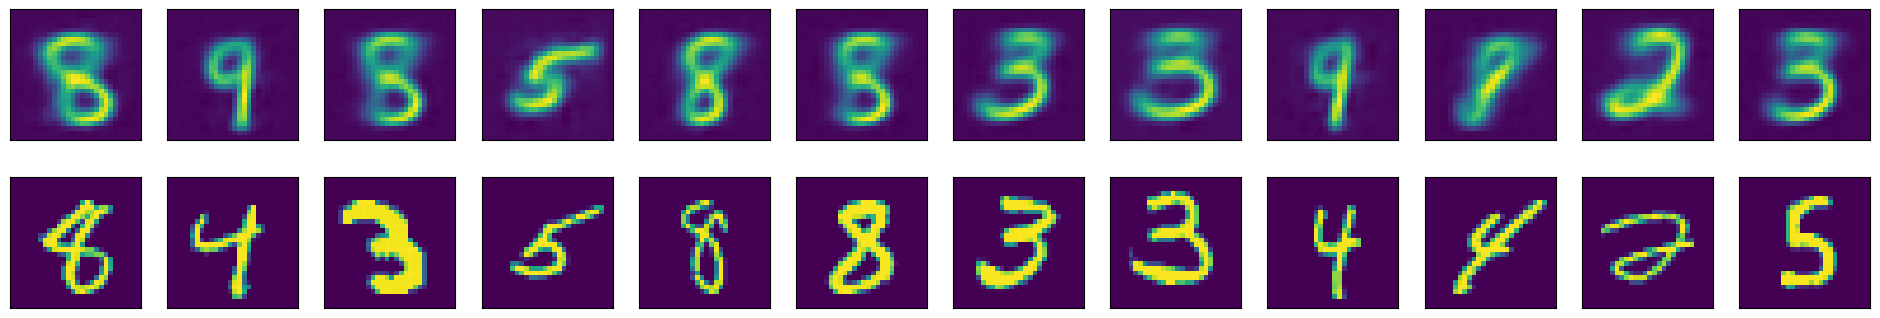

In [6]:
from IPython.display import clear_output
num_epochs = 25 

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_data in train_loader:  # Iterate over batches        
        inputs = batch_data[0].view(-1, 1, 28, 28).to(device)
        
        optimizer.zero_grad()

        # Forward pass
        reconstructed_batch, mu, logvar = model(inputs)
        
        # Compute the loss
        loss = model.loss(reconstructed_batch, inputs, mu, logvar)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print or log the average loss for the epoch\
    clear_output(wait=True)
    print(f'Epoch {epoch + 1}, Average Loss: {total_loss / 70000}')
    plt.figure(figsize=(24,4))
    for i in range(12):
        plt.subplot(2,12,i+1)
        plt.imshow(reconstructed_batch[i].reshape(28,28).detach().cpu().numpy())
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,12,i+13)
        plt.imshow(inputs[i].reshape(28,28).detach().cpu().numpy())
        plt.xticks([])
        plt.yticks([])
    plt.show()

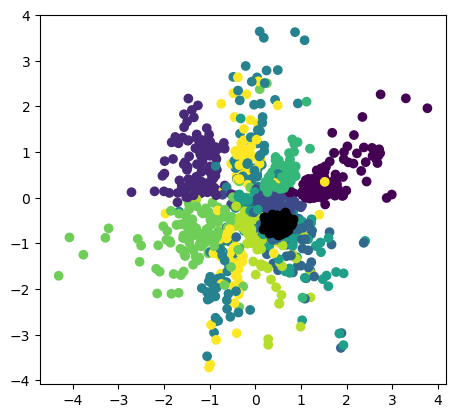

In [7]:
num_sample = 1000

h = model.encoder(mnist_data[:num_sample].view(-1, 1, 28, 28).to(device))
mu, logvar = h[:,:latent_dim], h[:,latent_dim:]
latent_representation = model.reparameterize(mu, logvar)

X = (latent_representation.reshape(num_sample, latent_dim)[:,:2].T).detach().cpu()
plt.scatter(X[0],X[1],c=labels[:num_sample].astype(int))
plt.gca().set_aspect('equal')

X2 = np.array([model.reparameterize(mu[0], logvar[0]).reshape(2).detach().cpu().numpy() for i in range(1000)]).T
plt.scatter(X2[0],X2[1],c='black')
plt.gca().set_aspect('equal')
plt.show()

plt.show()

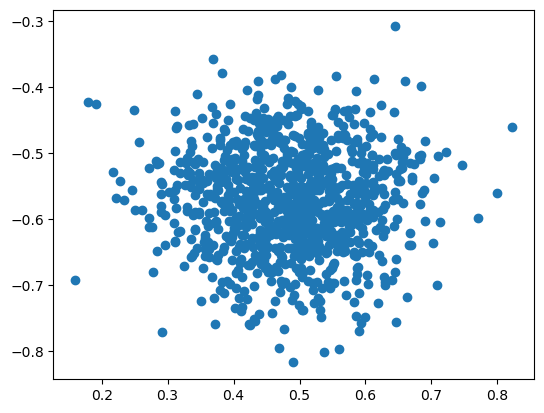

In [8]:
# X = np.array([model.reparameterize(mu[0], logvar[0]).reshape(2).detach().cpu().numpy() for i in range(1000)]).T
plt.scatter(X2[0],X2[1])
plt.gca().set_aspect('equal')
plt.show()

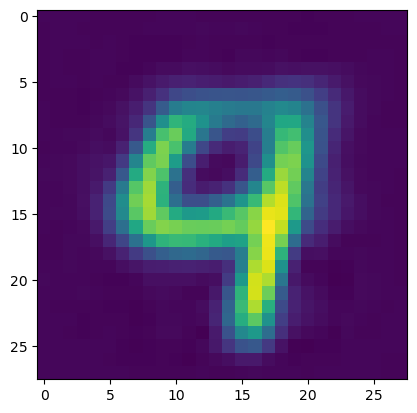

In [9]:
plt.imshow(model.decoder(torch.randn(latent_dim).reshape(1,2,1,1).to(device)).detach().cpu().reshape(28,28))